# Project 1 - Aurèle Bohbot, Quentin Guilhot, Yanis Tournier

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
import plotly.express as px
from numpy import where
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import r2_score
from collections import Counter
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel, f_regression
from sklearn.tree import ExtraTreeRegressor
import math as m
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,RandomForestClassifier, ExtraTreesClassifier
from sklearn.feature_selection import RFE
from sklearn.svm import SVR, LinearSVC, SVC
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.kernel_ridge import KernelRidge

In [5]:
X = pd.read_csv('X_train.csv').drop(columns=['id'])
Xt = pd.read_csv('X_test.csv')
y = pd.read_csv('y_train.csv')
to_drop = ['x104', 'x129', 'x489', 'x530']
X = X.drop(columns=to_drop)
y = y.drop(columns=['id'])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Handling outliers

In [122]:
## Univariate outliers

def detection(df,features):
    outlier_indices=[]
    
    for c in features:
        Q1, Q3 = np.percentile(df[c],25), np.percentile(df[c],75)
        
        #IQR calculation
        IQR = Q3 - Q1
        outlier_step = IQR * 1.5
        lower_range = Q1 - (outlier_step)
        upper_range = Q3 + (outlier_step)
        
        #Outlier detection                                    #Outlier indexes
        outlier_list_col=df[  (df[c] < lower_range) | (df[c] > upper_range)  ].index
        
        #Store indexes
        outlier_indices.extend(outlier_list_col)
        
    outlier_indices=Counter(outlier_indices)
    # number of outliers
    # If we have more then 2 outliers in a sample, this sample ll be drop
    multiple_outliers = list(i for i, v in outlier_indices.items() if v > 2 )
    #we are taking indexes
    
    return multiple_outliers

outliers = detection(X_train, X_train.columns)
X_train=X_train.drop(outliers,axis=0).reset_index(drop = True)
X_train.shape

### Handling missing values 

For the moment, we replace the missing values by the column's median. Depending on the results, we might implement a knn algorithm.

In [7]:
y_test = y_test.fillna(y_test.median())
y_train = y_train.fillna(y_train.median())
X_test = X_test.fillna(X_test.median())

X_train_filled = X_train.fillna(X_train.median())
X_test_filled = X_test.fillna(X_train.median())


In [471]:
scaler = MinMaxScaler()
scaler.fit(X_train_filled)
X_train_norm = scaler.transform(X_train_filled)
X_test_norm = scaler.transform(X_test_filled)

In [8]:
scaler = StandardScaler()
scaler.fit(X_train_filled)
X_train_norm = scaler.transform(X_train_filled)
X_test_norm = scaler.transform(X_test_filled)

### Handling feature selections

In [46]:
## Univariate feature selection with the highest variance
select_feature = SelectKBest(f_regression, k=(100)).fit(X_train_norm, y_train)
X_train_new = select_feature.transform(X_train_norm)
X_test_new = select_feature.transform(X_test_norm)
X_train_new.shape


/Users/yanistournier/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(969, 100)

In [398]:
## Feature selection with PCA

pca = PCA(n_components=5)
pca.fit(X_train_norm,y_train)
X_train_pca = pca.transform(X_train_norm)
X_test_pca = pca.transform(X_test_norm)

In [ ]:
## Feature selection/ranking with recursive feature elimination

X_train_RFE = X_train_norm.values
X_test_RFE = X_test_norm.values
y_train_RFE = y_train.values.reshape(-1)
clf_rf_3 = SVR(kernel="linear")      
rfe = RFE(estimator=clf_rf_3, n_features_to_select=20, step=1)
rfe = rfe.fit(X_train_RFE, y_train_RFE)

In [447]:
## Feature selection with select from model

clf = ExtraTreesClassifier(n_estimators=1000)
clf = clf.fit(X_train_norm, y_train)
model = SelectFromModel(clf, prefit=True)
X_train_new = model.transform(X_train_norm)
X_test_new = model.transform(X_test_norm)
print(X_train_new.shape,X_test_new.shape)

/var/folders/xz/2x_7tl010yn5bqd9lf1tsr3m0000gn/T/ipykernel_68857/3899921632.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf = clf.fit(X_train_norm, y_train)
/Users/yanistournier/opt/miniconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/yanistournier/opt/miniconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


(969, 388) (243, 388)


In [47]:
plt.hist(np.corrcoef(X_train_new).flatten()

array([ 1.        , -0.0609695 ,  0.1978404 , ..., -0.37708081,
       -0.12850677,  1.        ])

<AxesSubplot:>

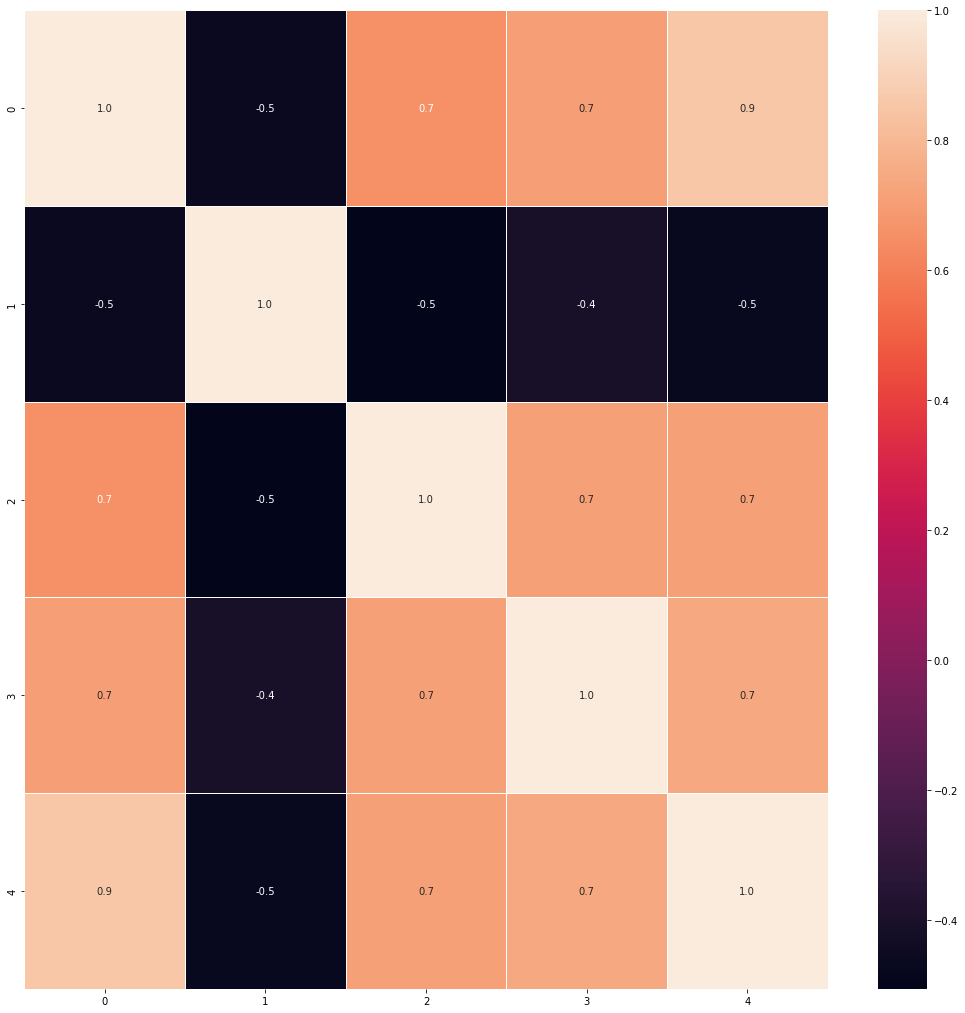

In [10]:
### Feature visualization
# correlation map
X_dtf = pd.DataFrame(X_train_new)
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(X_dtf.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

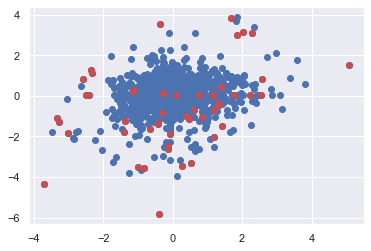

(49, 100) (969, 100)


(array([ 15,  55,  56,  62,  71, 118, 119, 184, 199, 220, 226, 233, 244,
        252, 319, 321, 322, 359, 395, 412, 434, 442, 452, 483, 512, 518,
        537, 558, 591, 592, 596, 620, 626, 631, 715, 718, 734, 756, 797,
        821, 828, 836, 838, 846, 867, 869, 892, 949, 956]),)

In [33]:
## Outlier detection with multivariate technique: gaussian mixture model
elenv = EllipticEnvelope(contamination=0.05)

pred = elenv.fit_predict(X_train_new)
anom_index=where(pred==-1)
values_anom = X_train_new[anom_index]

plt.scatter(X_train_new[:,0], X_train_new[:,1])
plt.scatter(values_anom[:,0],values_anom[:,1], color='r')
plt.show()
print(values_anom.shape,X_train_new.shape)
anom_index

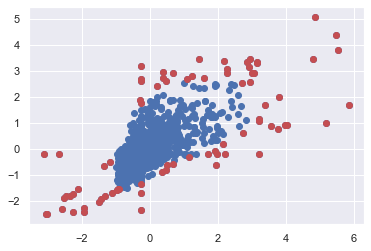

(78, 2) (969, 2)


(array([ 11,  30,  61,  71,  98, 102, 103, 112, 119, 152, 184, 199, 203,
        210, 220, 226, 244, 256, 264, 283, 296, 322, 383, 412, 423, 442,
        449, 459, 483, 489, 492, 512, 515, 521, 537, 547, 561, 563, 573,
        590, 596, 617, 620, 626, 631, 637, 647, 688, 697, 702, 712, 715,
        720, 722, 729, 732, 769, 793, 819, 821, 828, 846, 855, 862, 867,
        868, 885, 886, 897, 910, 920, 929, 932, 944, 949, 950, 956, 964]),)

In [539]:
## Outlier detection with multivariate technique: LOF
elenv = LocalOutlierFactor(n_neighbors=100)

pred = elenv.fit_predict(X_train_new)
anom_index=where(pred==-1)
values_anom = X_train_new[anom_index]

plt.scatter(X_train_new[:,0], X_train_new[:,1])
plt.scatter(values_anom[:,0],values_anom[:,1], color='r')
plt.show()
print(values_anom.shape,X_train_new.shape)
anom_index

/Users/yanistournier/opt/miniconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/yanistournier/opt/miniconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


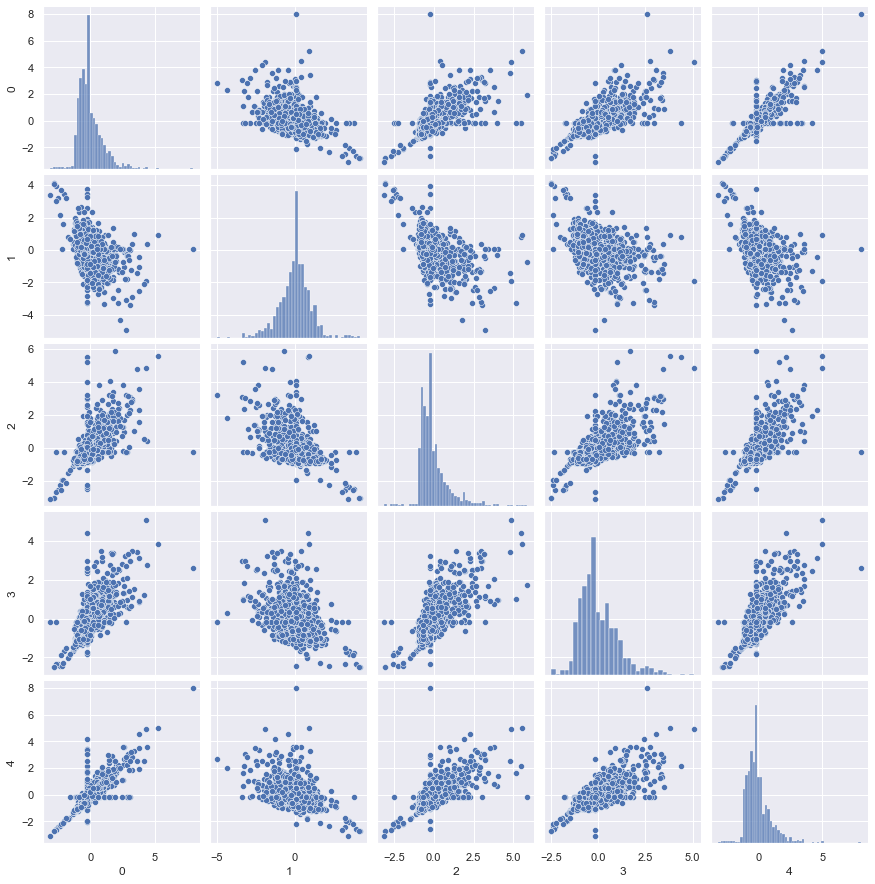

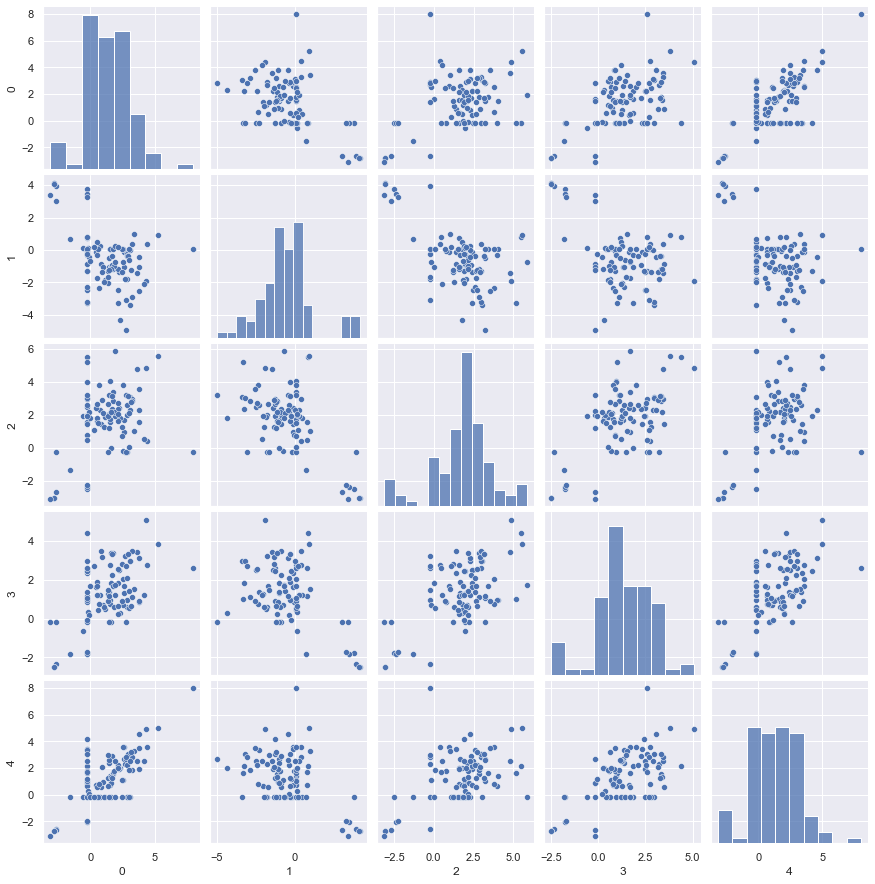

In [12]:
X_anom_dtf = pd.DataFrame(values_anom)
sns.set()
sns.pairplot(X_dtf, size = 2.5)
sns.pairplot(X_anom_dtf, size = 2.5)
plt.show();

In [34]:
## What do you with outliers
# 1/ just trying to drop them

X_train_less_outliers = np.delete(X_train_new,anom_index, axis=0)
Y_train_less_outliers = np.delete(y_train.values,anom_index, axis=0)
print(X_train_less_outliers.shape,Y_train_less_outliers.shape)

(920, 100) (920, 1)


/Users/yanistournier/opt/miniconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


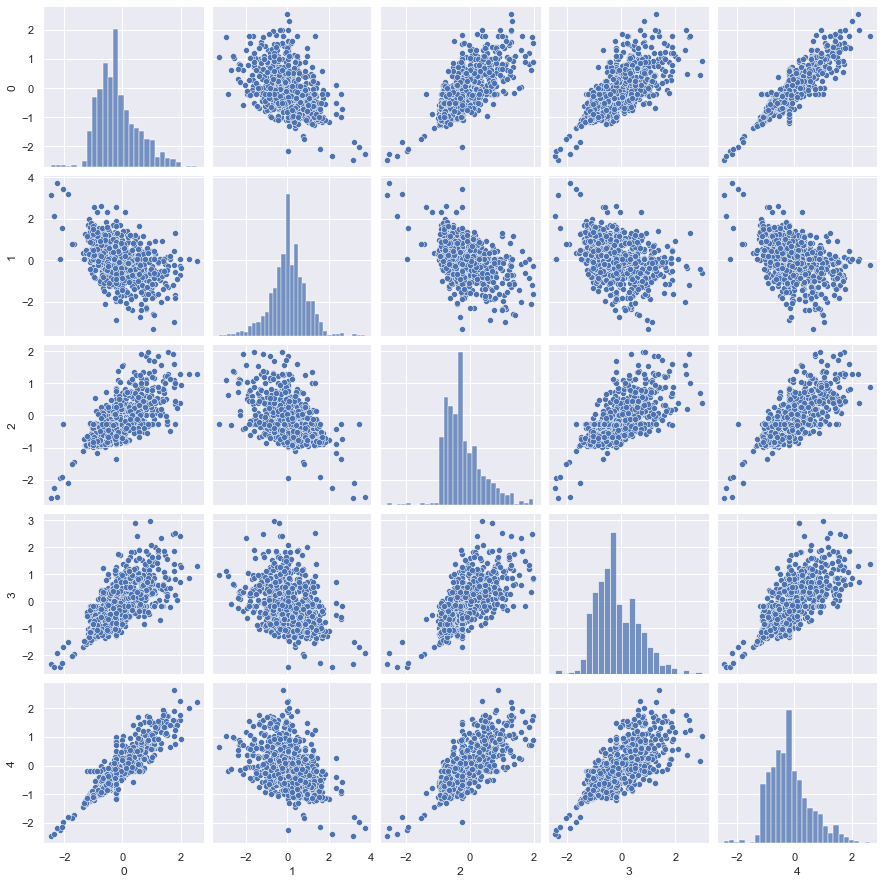

In [17]:
X_pd_final = pd.DataFrame(X_train_less_outliers)
sns.pairplot(X_pd_final, size = 2.5)

In [21]:
model = LinearRegression()
model.fit(X_train_new, y_train)
y_pred = model.predict(X_test_new)
y_pred.shape
score = r2_score(y_test, y_pred)
score

0.36764149608422714

In [38]:
model = Ridge(alpha=2)
model.fit(X_train_less_outliers, Y_train_less_outliers)
y_pred = model.predict(X_test_new)
y_pred.shape
score = r2_score(y_test, y_pred)
score

0.3624513122372075

In [22]:
model = SVC(kernel='rbf', gamma='auto')
model.fit(X_train_new, y_train)
y_pred = model.predict(X_test_new)
y_pred.shape
score = r2_score(y_test, y_pred)
score

/Users/yanistournier/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.3242979540811659

In [23]:
## RFD with normalized data

regr = RandomForestRegressor(max_depth=20, random_state=0)
regr.fit(X_train_new, y_train)
y_pred = regr.predict(X_test_new)
score = r2_score(y_test, y_pred)
score

/var/folders/xz/2x_7tl010yn5bqd9lf1tsr3m0000gn/T/ipykernel_77665/553895817.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(X_train_new, y_train)


0.5277493085257072

In [572]:
## RFD with normalize data and without outliers

regr = RandomForestRegressor(max_depth=20, random_state=0)
regr.fit(X_train_less_outliers, Y_train_less_outliers)
y_pred = regr.predict(X_test_new)
score = r2_score(y_test, y_pred)
score

/var/folders/xz/2x_7tl010yn5bqd9lf1tsr3m0000gn/T/ipykernel_68857/3829155779.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(X_train_less_outliers, Y_train_less_outliers)


0.3722158875296746